# Предобработка и анализ текста в постах социальной сети

In [112]:
# основные библиотеки
import os
import sys
import re
import warnings
from collections import Counter, OrderedDict
from typing import List, Optional

# библиотеки для манипулирования в IPython
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from IPython.display import clear_output


# основные библиотеки для анализа данных
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns


tqdm_notebook.pandas()
# игнорируем вывод предупреждений
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# загрузка spacy
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download ru_core_news_lg # выбрана самая большая русскоязычная модель в spacy
clear_output()

In [76]:
# импорт основных библиотек для NLP
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize.casual import casual_tokenize
from wordcloud import WordCloud, STOPWORDS


nltk.download('stopwords')
nlp = spacy.load("ru_core_news_lg")
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))
clear_output()

In [107]:
# импорт библиотек для проведения кластерного анализа
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import silhouette_score

In [5]:
parent_dir = os.path.dirname(os.getcwd())
post_file_name = "posts_30_07_2022_13_23_17.csv"
post_file_path = os.path.join(parent_dir, os.path.join("datasets", post_file_name))

In [6]:
posts_df = pd.read_csv(post_file_path)

## Поверхностный взгляд на данные

In [7]:
posts_df.head()

,id,text,likes,views,reposts
0,1728892,Позапрошлым летом я купила очки от солнца за 1...,104,19055,25
1,1728858,"У меня есть друг Антон, дружим уже больше 20 л...",253,41958,44
2,1728829,"Влезла в телефон мужа, пока он отсыпался после...",413,41043,109
3,1728805,"Вы когда-нибудь задумывались, как фильмы, кото...",281,45951,22
4,1728769,"Мне 35, брату 26. Так вышло, что живём с мамой...",554,78091,36


In [137]:
posts_df.shape

(9999, 5)

In [8]:
posts_df.iloc[0]

id                                                   1728892
text       Позапрошлым летом я купила очки от солнца за 1...
likes                                                    104
views                                                  19055
reposts                                                   25
Name: 0, dtype: object

In [9]:
posts_df.iloc[0]["text"]

'Позапрошлым летом я купила очки от солнца за 1900 рублей. Нефирменные, просто классно сели. На следующий день я нашла эти очки на сайте за 372 рубля. С тех пор я всем магазинам и кафе оставляю плохие отзывы на сайтах и аккаунтах в соцсетях, жалуюсь администраторам, всегда нахожу минус и начинаю долбить, даже если услуга была оказана нормально. Я знаю, что 90% бизнеса — это тупо бессовестная нажива. Ибо нефиг.\n\n#Подслушано_алчность@overhear'

In [10]:
posts_df.describe()

,id,likes,views,reposts
count,9.999000e+03,9999.000000,9.999000e+03,9999.000000
mean,1.636715e+06,1371.490349,1.748342e+05,190.217222
std,4.788404e+04,1308.983925,1.167538e+05,357.979143
min,1.557339e+06,11.000000,1.905500e+04,0.000000
25%,1.597387e+06,779.000000,1.141570e+05,44.000000
50%,1.633657e+06,1030.000000,1.470340e+05,92.000000
75%,1.675822e+06,1476.000000,1.801665e+05,193.500000
max,1.728892e+06,28413.000000,1.873398e+06,8342.000000


Разъединение текста комментария от тега

In [11]:
process_posts_df = posts_df.copy(deep=True)
process_posts_df["tag"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[-1]
                                                                 .replace("\r\n\r\n#", "")
                                                                 .replace("@overhear", "")
                                                                 .replace("\r", "")
                                                                 .replace("\n", " ")
                                                                 .replace("_", "")
                                                                 .lower()
                                                 if len(str(x).split("Подслушано")) > 1 else None)
process_posts_df["text"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[0].replace("\r", "").replace("\n", " ").replace("\t", " "))

In [12]:
process_posts_df.head(10)

,id,text,likes,views,reposts,tag
0,1728892,Позапрошлым летом я купила очки от солнца за 1...,104,19055,25,алчность
1,1728858,"У меня есть друг Антон, дружим уже больше 20 л...",253,41958,44,дружба
2,1728829,"Влезла в телефон мужа, пока он отсыпался после...",413,41043,109,месть
3,1728805,"Вы когда-нибудь задумывались, как фильмы, кото...",281,45951,22,кино
4,1728769,"Мне 35, брату 26. Так вышло, что живём с мамой...",554,78091,36,семья
5,1728755,"Замужем, есть дочь 2,5 года. Во время секса с ...",300,79086,84,похоть
6,1728733,Мое кухонное ведро для мусора всегда в идеальн...,276,40880,20,странное
7,1728716,"Меня всегда искренне бесит, когда парни называ...",735,55713,289,бесит
8,1728695,"Работаю в системе образования, работаю с семья...",310,44419,20,наблюдения
9,1728685,Люблю нюхать свои пальцы после мастурбации. По...,165,45079,31,пошлое


Распределение комментариев по тэгам

In [13]:
tag_counts = process_posts_df["tag"].value_counts(sort=True)
tag_counts

провал                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               799
семья                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [14]:
# удалим строки с тегами, которые соответствуют только 1 комментарию
process_posts_df = process_posts_df.drop(process_posts_df[process_posts_df["tag"].isin(tag_counts[tag_counts ==  1].index.tolist())].index)

Рассмотрим, под какими тегами посты набирают больший отклик среди пользователей и имеют большую среднюю длину

In [15]:
tag_statistic = process_posts_df.drop(columns=["id"], axis=1)
tag_statistic["post_length"] = tag_statistic["text"].apply(len)
tag_statistic = tag_statistic.drop(columns=["text"], axis=1).groupby(by=["tag"]).mean()
tag_statistic.head()

,likes,views,reposts,post_length
tag,,,,
алчность,1290.051020,176787.224490,114.020408,513.158163
бабушки,1371.210084,148193.655462,124.571429,450.159664
бесит,1337.487234,172974.840426,171.242553,463.255319
бомжи,1352.055556,147995.833333,220.944444,365.888889
великаяпобеда,1531.500000,143200.750000,55.000000,437.750000


In [16]:
# топ 10 тегов, посты которых набирают больше всего в среднем просмотров
tag_statistic.sort_values(by=["views"], ascending=False).head(10)

,likes,views,reposts,post_length
tag,,,,
пошлое,1029.033138,253910.000000,491.477583,381.099415
предательство,1350.534783,217698.478261,219.521739,489.734783
счастье,2636.937500,207164.062500,269.078125,427.859375
месть,1971.632184,206021.563218,187.091954,452.735632
пиздец,1322.540541,204894.108108,275.858108,478.648649
семья,1712.725744,199620.539457,156.970246,515.208279
ревность,1256.000000,199293.736842,177.973684,541.631579
любовь ❤,1906.684211,198325.631579,202.782895,479.217105
зависть,1395.406780,195734.169492,187.288136,491.796610


In [17]:
# топ 10 тегов, посты которых набирают больше всего в среднем лайков
tag_statistic.sort_values(by=["likes"], ascending=False).head(10)

,likes,views,reposts,post_length
tag,,,,
счастье,2636.937500,207164.062500,269.078125,427.859375
добро,2428.452703,178250.993243,70.493243,440.222973
успех,2187.889764,189003.944882,226.204724,441.515748
москва,2044.500000,161750.000000,35.000000,534.500000
месть,1971.632184,206021.563218,187.091954,452.735632
коты ^^,1951.215278,155656.097222,270.631944,406.215278
любовь ❤,1906.684211,198325.631579,202.782895,479.217105
мистика,1775.105263,186115.526316,123.210526,435.921053
иллюстрация,1729.500000,118913.166667,142.000000,438.500000


In [18]:
# топ 10 тегов, посты которых набирают больше всего в среднем репостов
tag_statistic.sort_values(by=["reposts"], ascending=False).head(10)

,likes,views,reposts,post_length
tag,,,,
пошлое,1029.033138,253910.000000,491.477583,381.099415
фууу,804.458716,181539.614679,375.215596,390.087156
коронавирус 👑,1426.750000,142983.000000,334.500000,333.750000
пиздец,1322.540541,204894.108108,275.858108,478.648649
коты ^^,1951.215278,155656.097222,270.631944,406.215278
счастье,2636.937500,207164.062500,269.078125,427.859375
лайфхак,1422.370079,148365.133858,259.409449,333.881890
похоть,790.341040,192878.439306,236.023121,397.381503
кино,1376.512821,164566.692308,226.743590,457.641026


In [19]:
# топ 10 тегов, посты которых имеют наибольшую среднюю длину
tag_statistic.sort_values(by=["post_length"], ascending=False).head(10)

,likes,views,reposts,post_length
tag,,,,
ревность,1256.000000,199293.736842,177.973684,541.631579
москва,2044.500000,161750.000000,35.000000,534.500000
ненависть,1159.770833,166776.656250,112.239583,522.197917
семья,1712.725744,199620.539457,156.970246,515.208279
алчность,1290.051020,176787.224490,114.020408,513.158163
ебанько,1204.425000,194548.487500,223.937500,493.825000
зависть,1395.406780,195734.169492,187.288136,491.796610
предательство,1350.534783,217698.478261,219.521739,489.734783
жестокость,1212.861842,166842.052632,104.019737,482.585526


Распределение количества слов и длины постов

<AxesSubplot:xlabel='word number', ylabel='Density'>

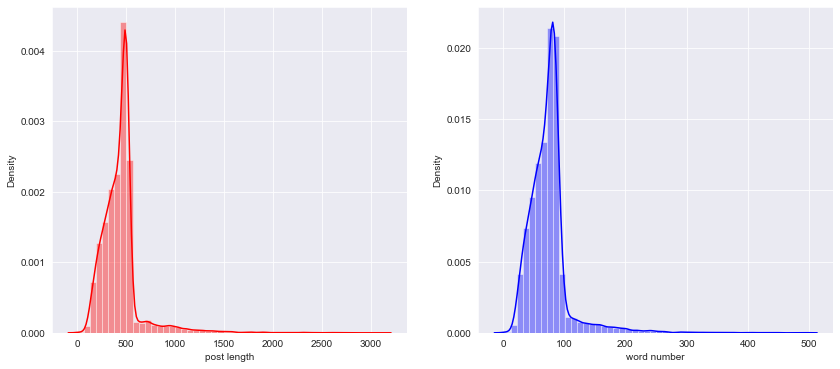

In [20]:
train_len = process_posts_df["text"].apply(len).rename("post length")
train_count = process_posts_df["text"].apply(lambda row: len(str(row).split(" "))).rename("word number")
fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
sns.distplot(train_len,color='red')
fig.add_subplot(1,2,2)
sns.distplot(train_count,color='blue')

Самые распространенные слова, употребляющиеся в постах

In [21]:
def plot_most_frequency_word_cloud(document: str, stop_words: set = RUSSIAN_STOPWORDS) -> None:
    """Отрисовка облаков слов для наиболее частых."""
    cloud = WordCloud(width=800, height=600, stopwords=stop_words).generate(document)
    plt.figure(figsize=(16,10))
    plt.imshow(cloud)
    plt.axis('off')

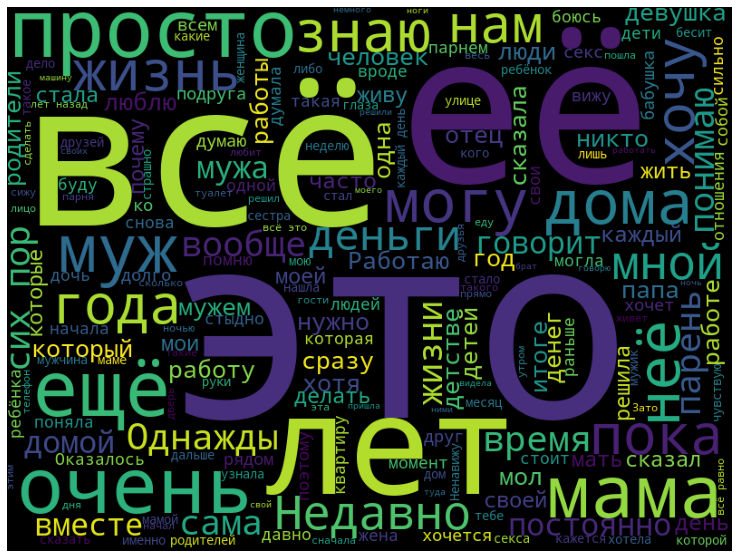

In [22]:
plot_most_frequency_word_cloud(" ".join(process_posts_df["text"].tolist()))

## Очистка данных

In [23]:
def clean_data(string: str) -> str:
    """Функция очистки данных."""
    letters_only = re.sub("[^а-яА-ЯёЁ]", " ", string)
    lowercase_text = letters_only.lower()
    string_without_stopwords = " ".join([word for word in lowercase_text.split()
                                         if word not in RUSSIAN_STOPWORDS])
    return string_without_stopwords

In [24]:
clean_posts_df = process_posts_df.drop(columns=["id"], axis=1)

In [25]:
clean_posts_df["text"] = process_posts_df["text"].progress_apply(clean_data)

  0%|          | 0/9985 [00:00<?, ?it/s]

In [26]:
def text_lemmatization(row: str) -> str:
    """Функция лемматизации."""
    doc = nlp(row)
    return " ".join([token.lemma_ for token in doc])

In [27]:
clean_posts_df_with_lemmatization = clean_posts_df.copy()
clean_posts_df_with_lemmatization["text"] = clean_posts_df_with_lemmatization["text"]\
                                            .progress_apply(text_lemmatization)

  0%|          | 0/9985 [00:00<?, ?it/s]

Облако слов для не лемматизированного текста

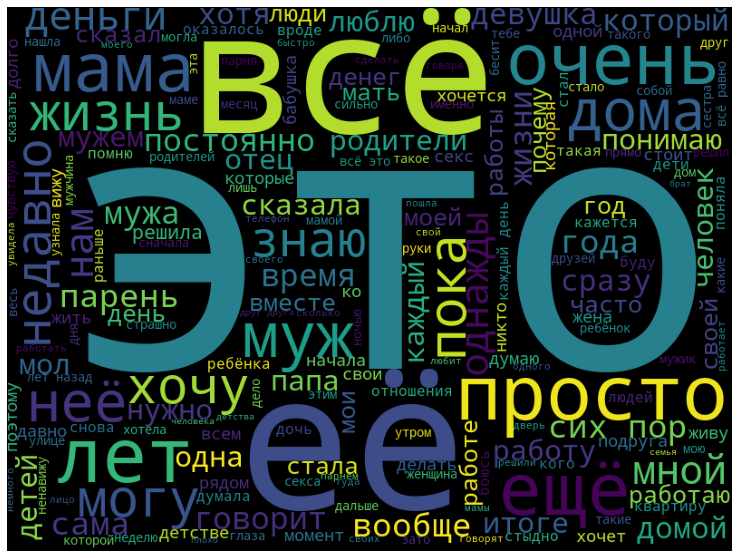

In [28]:
plot_most_frequency_word_cloud(" ".join(clean_posts_df["text"].tolist()))

Облако слов для лемматизированных текстов

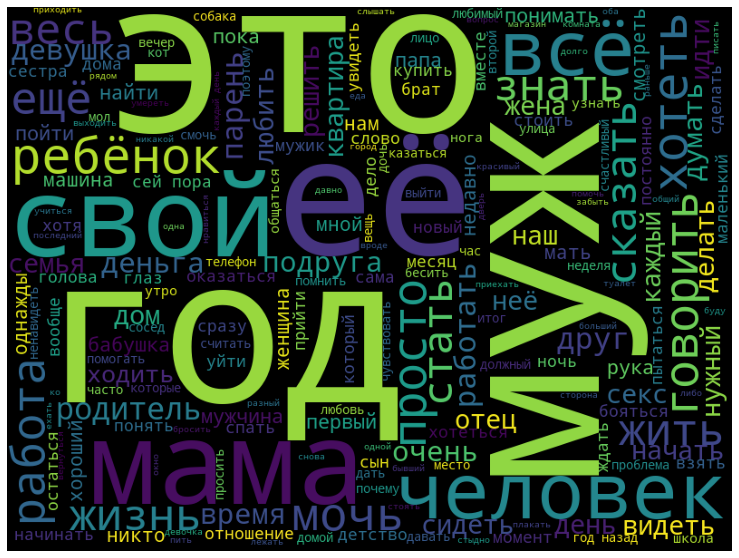

In [29]:
plot_most_frequency_word_cloud(" ".join(clean_posts_df_with_lemmatization["text"].tolist()))

## Анализ текстовых данных

In [30]:
document = " ".join(clean_posts_df_with_lemmatization["text"].tolist())

In [31]:
max_chunk_size = nlp.max_length
document_chunks = [document[i : i + max_chunk_size]
                   for i in range(0, len(document), max_chunk_size)]

In [32]:
docs = []
for document_chunk in tqdm(document_chunks):
    doc = nlp(document_chunk)
    docs.append(doc)

100%|██████████| 4/4 [03:05<00:00, 46.36s/it]


### Частеречный анализ и анализ сущностей

In [33]:
words = [] # слова
nouns = [] # существительные
verbs = [] # глаголы
personal_noun = [] # имена собственные
pron = [] # местоимения
adj = [] # прилагательные

for doc in tqdm(docs):
    for token in doc:
        if token.pos_ != 'SPACE' and token.pos_ != 'PUNCT':
            words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)
        if token.pos_ == "NOUN":
            nouns.append(token.text)
        if token.pos_ == "PRON":
            pron.append(token.text)
        if token.pos_ == "ADJ":
            adj.append(token.text)
        if token.pos_ == "PROPN":
            personal_noun.append(token.text)

100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


In [34]:
print(f"Всего слов: {len(words)}")
print(f"Всего существительных: {len(nouns)} ({round(len(nouns) / len(words), 3)})")
print(f"Всего имен собственных: {len(personal_noun)} ({round(len(personal_noun) / len(words), 3)})")
print(f"Всего глаголов: {len(verbs)} ({round(len(verbs) / len(words), 3)})")
print(f"Всего прилагательных: {len(adj)} ({round(len(adj) / len(words), 3)})")
print(f"Всего местоимений: {len(pron)} ({round(len(pron) / len(words), 3)})")

Всего слов: 421608
Всего существительных: 162120 (0.385)
Всего имен собственных: 4386 (0.01)
Всего глаголов: 129875 (0.308)
Всего прилагательных: 44613 (0.106)
Всего местоимений: 14271 (0.034)


In [35]:
print(f"Пример слова: {words[0]}")
print(f"Пример существительного: {nouns[0]}")
print(f"Пример имени собственного: {personal_noun[0]}")
print(f"Пример глагола: {verbs[0]}")
print(f"Пример прилагательного: {adj[0]}")
print(f"Пример местоимения: {pron[0]}")

Пример слова: позапрошлый
Пример существительного: лето
Пример имени собственного: антон
Пример глагола: купить
Пример прилагательного: позапрошлый
Пример местоимения: это


In [36]:
people = []
locations = []
organisations = []

for doc in tqdm(docs):
    for entity in doc.ents:
        if entity.label_ == "ORG":
            organisations.append(entity.text)
        if entity.label_ == "PER":
            people.append(entity.text)
        if entity.label_ == "LOC":
            locations.append(entity.text)

100%|██████████| 4/4 [00:00<00:00, 137.94it/s]


In [37]:
print(f"Всего людей: {len(people)} ({round(len(people) / len(words), 3)})")
print(f"Всего географических объектов: {len(locations)} ({round(len(locations) / len(words), 3)})")
print(f"Всего организаций: {len(organisations)} ({round(len(organisations) / len(words), 3)})")

Всего людей: 906 (0.002)
Всего географических объектов: 624 (0.001)
Всего организаций: 172 (0.0)


In [38]:
print(f"Пример людей: {people[0]}")
print(f"Пример географических объектов: {locations[0]}")
print(f"Пример организаций: {organisations[0]}")

Пример людей: антон
Пример географических объектов: москва
Пример организаций: ооо


In [39]:
def sort_by_frequency(data, reverse = True):
    """Сортировка данных по их частоте"""
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))

    return data_sorted_by_freq

In [40]:
words_freq = list(sort_by_frequency(words))
nouns_freq = list(sort_by_frequency(nouns))
verbs_freq = list(sort_by_frequency(verbs))
personal_noun_freq = list(sort_by_frequency(personal_noun))
pron_freq = list(sort_by_frequency(pron))
adj_freq = list(sort_by_frequency(adj))

people_freq = list(sort_by_frequency(people))
locations_freq = list(sort_by_frequency(locations))
organisations_freq = list(sort_by_frequency(organisations))

Наиболее частые:

* слова

In [41]:
words_freq[0:10]

['год', 'это', 'мой', 'свой', 'муж', 'человек', 'её', 'всё', 'мама', 'ребёнок']

* существительные

In [42]:
nouns_freq[0:10]

['год',
 'муж',
 'человек',
 'мама',
 'ребёнок',
 'день',
 'работа',
 'жизнь',
 'время',
 'парень']

* глаголы

In [43]:
verbs_freq[0:10]

['жить',
 'хотеть',
 'говорить',
 'знать',
 'сказать',
 'стать',
 'любить',
 'работать',
 'делать',
 'думать']

* имена собственные

In [44]:
personal_noun_freq[0:10]

['москва',
 'неё',
 'тётя',
 'голова',
 'россия',
 'деньга',
 'куни',
 'мороз',
 'нога',
 'ок']

* местоимения

In [45]:
pron_freq[0:10]

['это',
 'её',
 'друг',
 'всё',
 'никто',
 'мной',
 'нам',
 'который',
 'кто',
 'которые']

* прилагательные

In [46]:
adj_freq[0:10]

['первый',
 'хороший',
 'нужный',
 'новый',
 'сама',
 'маленький',
 'бывший',
 'последний',
 'второй',
 'молодой']

* организации

In [47]:
organisations_freq[0:10]

['вк', 'зп', 'мжм', 'гибдд', 'ммм', 'нг', 'вконтакте', 'мгу', 'окр', 'сизо']

* географические объекты

In [48]:
locations_freq[0:10]

['москва',
 'россия',
 'европа',
 'германия',
 'сибирь',
 'ссср',
 'китай',
 'москве',
 'турция',
 'сочи']

* люди

In [49]:
people_freq[0:10]

['тётя',
 'куни',
 'питер',
 'вагин',
 'катя',
 'барби',
 'шлёт',
 'фон',
 'гарри поттер',
 'тётушка']

### Анализ N-грамм

In [50]:
def create_bigram(tokens: list) -> list:
    """Создание биграмм на основе токенов."""
    _bigrams = nltk.bigrams(tokens)
    return list(_bigrams)

In [51]:
bigrams_list = create_bigram(words)
bigrams = [" ".join(bigram) for bigram in list(bigrams_list)]

In [52]:
bigrams[100:110]

['затишье первый',
 'первый выйти',
 'выйти связь',
 'связь ирина',
 'ирина поговори',
 'поговори антошей',
 'антошей бухать',
 'бухать полгода',
 'полгода слушать',
 'слушать никто']

In [53]:
bigram_frequency = sort_by_frequency(bigrams)

In [133]:
def get_top_n_from_order_dict(ordered_dict: OrderedDict,  n: int) -> list:
    """Нахождение первых n-элементов из order dict."""
    items = list(ordered_dict.items())
    if len(items) < n:
        n = len(items)
    return [items[i] for i in range(n)]

In [55]:
top_bigram = get_top_n_from_order_dict(bigram_frequency,25)

Самые частые биграммы

In [56]:
top_bigram

[('сей пора', 538),
 ('год назад', 386),
 ('каждый день', 261),
 ('молодой человек', 217),
 ('всё равный', 204),
 ('день рождение', 192),
 ('несколько год', 187),
 ('друг друга', 183),
 ('тот пора', 173),
 ('выйти замуж', 172),
 ('этот время', 168),
 ('очень любить', 156),
 ('весь это', 142),
 ('пройти год', 130),
 ('новый год', 127),
 ('мой жизнь', 123),
 ('пять год', 113),
 ('следующий день', 107),
 ('мой родитель', 102),
 ('т д', 100),
 ('мой муж', 98),
 ('человек которые', 95),
 ('весь этот', 92),
 ('мой мама', 88),
 ('пара день', 87)]

In [57]:
def visualize_list_of_tuple(data):
    """Визуализация списка кортежей."""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center', alpha=0.5)
    plt.yticks(y_pos, list1)
    plt.show()

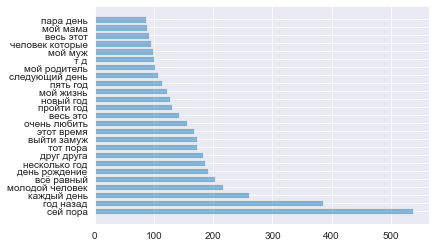

In [58]:
visualize_list_of_tuple(top_bigram)

Создадим наборы из уникальных слов разных частей речи и сущностей

In [59]:
unique_words = set(words)
unique_nouns = set(nouns)
unique_verbs = set(verbs)
unique_personal_noun = set(personal_noun)
unique_pron = set(pron)
unique_adj = set(adj)

unique_people = set(people)
unique_locations = set(locations)
unique_organisations = set(organisations)

Рассмотрим биграммы из двух существительных

In [67]:
def get_bigrams(
        bigrams: List[str],
        bag_of_words_for_first_word: List[str],
        bag_of_words_for_second_word: Optional[List[str]] = None,
) -> List[str]:
    """Поиск биграмм с двумя существительными."""
    NN_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in bag_of_words_for_first_word and \
                (bag_of_words_for_second_word is not None
                 and second_word in bag_of_words_for_second_word):
            NN_bigrams.append(" ".join((first_word,second_word)))
    return NN_bigrams


nn_bigrams = get_bigrams(bigrams_list, unique_nouns, unique_nouns)
nn_bigrams_freq = sort_by_frequency(nn_bigrams)

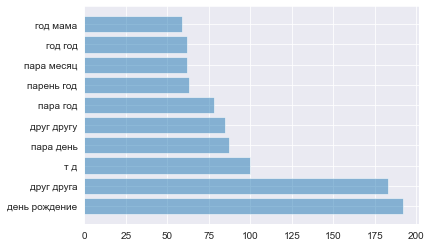

In [69]:
top_10_NN_bigram = get_top_n_from_order_dict(nn_bigrams_freq, 10)
visualize_list_of_tuple(top_10_NN_bigram)

Рассмотрим биграммы, где первое слово глагол

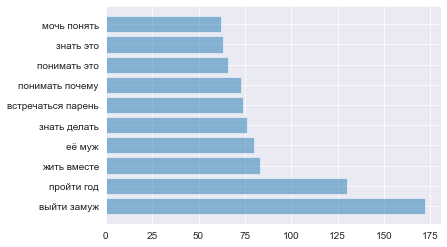

In [70]:
vw_bigrams = get_bigrams(bigrams_list, unique_verbs, unique_words)
vw_bigrams_freq = sort_by_frequency(vw_bigrams)
top_10_vw_bigram = get_top_n_from_order_dict(vw_bigrams_freq, 10)
visualize_list_of_tuple(top_10_vw_bigram)

Рассмотрим биграммы, где первое слово местоимение

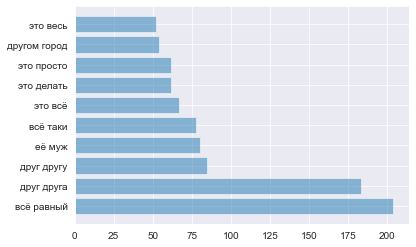

In [71]:
pw_bigrams = get_bigrams(bigrams_list, unique_pron, unique_words)
pw_bigrams_freq = sort_by_frequency(pw_bigrams)
top_10_pw_bigram = get_top_n_from_order_dict(pw_bigrams_freq, 10)
visualize_list_of_tuple(top_10_pw_bigram)

Рассмотрим биграммы, где первое слово прилагательное

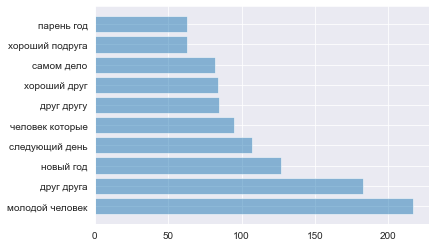

In [72]:
aw_bigrams = get_bigrams(bigrams_list, unique_adj, unique_words)
aw_bigrams_freq = sort_by_frequency(aw_bigrams)
top_10_aw_bigram = get_top_n_from_order_dict(aw_bigrams_freq, 10)
visualize_list_of_tuple(top_10_aw_bigram)

### Латентно-семантический анализ

In [74]:
posts_for_lsa = clean_posts_df_with_lemmatization[["text", "tag"]]

In [77]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=posts_for_lsa["text"]).toarray()

In [79]:
len(tfidf.vocabulary_)

31371

In [81]:
tfidf_docs_df = pd.DataFrame(tfidf_docs)
tfidf_docs_df = tfidf_docs_df - tfidf_docs_df.mean()
tfidf_docs_df.shape

(9985, 31371)

#### PCA

In [90]:
n_components = 3

In [91]:
pca = PCA(n_components=n_components)
pca.fit(tfidf_docs_df)

PCA(n_components=3)

In [92]:
pca_topic_vectors = pca.transform(tfidf_docs_df)
columns = [f"topic_{i}" for i in range(n_components)]
pca_topic_vectors_df = pd.DataFrame(pca_topic_vectors, columns=columns)

In [93]:
pca_topic_vectors_df.round(3).head(10)

,topic_0,topic_1,topic_2
0,-0.063,0.018,0.029
1,0.065,-0.079,-0.083
2,-0.005,-0.053,0.009
3,-0.043,-0.003,-0.002
4,0.176,0.155,0.008
5,0.041,-0.212,-0.117
6,-0.043,0.030,0.023
7,-0.030,-0.055,-0.085
8,0.037,0.002,0.115
9,-0.040,-0.045,-0.041


In [95]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys(),)))

In [100]:
weights_df = pd.DataFrame(pca.components_, columns=terms, index=[f"topic_{i}" for i in range(n_components)])
weights_df.head().round(3)

,ааа,аах,аб,абдоминопластику,...,ёпта,ёрзать,ёршик,ёршиком
topic_0,-0.0,-0.001,0.000,0.001,...,0.000,-0.0,-0.002,-0.0
topic_1,-0.0,-0.000,-0.001,-0.001,...,-0.000,0.0,-0.000,0.0
topic_2,-0.0,-0.001,-0.001,0.000,...,-0.001,0.0,0.002,0.0


#### SVD

In [103]:
svd = TruncatedSVD(n_components=n_components, n_iter=200)
svd_topic_vectors = svd.fit_transform(tfidf_docs_df.values)

In [104]:
svd_topic_vectors_df = pd.DataFrame(svd_topic_vectors, columns=columns)
svd_topic_vectors_df.round(3).head()

,topic_0,topic_1,topic_2
0,-0.064,0.017,0.030
1,0.065,-0.079,-0.082
2,-0.005,-0.054,0.009
3,-0.043,-0.003,-0.003
4,0.176,0.156,0.009


### Латентное размещение Дирихле

In [105]:
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=posts_for_lsa["text"]).toarray())

In [109]:
columns_nums_ldia, terms_ldia = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys(),)))
bow_docs.columns = terms_ldia

In [110]:
bow_docs.head()

,ааа,аах,аб,абдоминопластику,...,ёпта,ёрзать,ёршик,ёршиком
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
3,0,0,0,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0


In [111]:
ldia = LatentDirichletAllocation(n_components=n_components, learning_method="batch")
ldia.fit(bow_docs)
ldia.components_.shape

(3, 31371)

In [114]:
components_ldia = pd.DataFrame(ldia.components_.T, index=terms_ldia, columns=columns)
components_ldia.round(3).head()

,topic_0,topic_1,topic_2
ааа,1.331,1.634,2.035
аах,3.333,0.334,0.334
аб,0.333,0.364,2.303
абдоминопластику,0.333,0.336,1.330
абзац,0.333,0.333,1.333


In [116]:
ldia_topic_vectors = ldia.transform(bow_docs)
ldia_topic_vectors_df = pd.DataFrame(ldia_topic_vectors, columns=columns)
ldia_topic_vectors_df.round(3).head()

,topic_0,topic_1,topic_2
0,0.010,0.009,0.981
1,0.003,0.893,0.104
2,0.009,0.980,0.011
3,0.906,0.008,0.086
4,0.007,0.008,0.985


### Кластерный анализ

In [119]:
n_clusters = 3

In [120]:
clear_text_list = clean_posts_df_with_lemmatization["text"].to_list()

In [124]:
cluster_tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
clustering_data = cluster_tfidf.fit_transform(clear_text_list)
k_means = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=150)
k_means.fit(clustering_data)

KMeans(max_iter=150, n_clusters=3)

In [125]:
k_means_predictions = k_means.predict(clustering_data)

In [126]:
len(k_means_predictions)

9985

In [128]:
posts_with_cluster = clean_posts_df_with_lemmatization[["text"]]
posts_with_cluster["cluster"] = k_means_predictions

In [129]:
posts_with_cluster.head()

,text,cluster
0,позапрошлый лето купить очки солнце рубль нефи...,2
1,друг антон дружить год любить брат родный год ...,1
2,влезть телефон муж пока отсыпаться очередной п...,1
3,задумываться фильм которые нам казаться нереал...,2
4,брат выйти живём мама трёшке отец уйти семья б...,0


Проведем сравнительный анализ между кластерами и рассмотрим, какие биграммы чаще всего встречаются в каждом из кластеров

In [152]:
clusters_statistic = {}

for i in range(n_clusters):
    cluster_text_ = posts_with_cluster[posts_with_cluster["cluster"] == i]["text"]\
                                                                       .to_list()
    tokens_ = casual_tokenize(" ".join(cluster_text_))
    bigrams = [" ".join(bigram_) for bigram_ in create_bigram(tokens_)]
    bigrams_frequency = sort_by_frequency(bigrams)
    top_bigrams = get_top_n_from_order_dict(bigrams_frequency, 10)

    clusters_statistic.update({i: top_bigrams})

In [154]:
cluster_data = {}
for i in clusters_statistic.keys():
    bigrams_ = [v[0] for v in clusters_statistic[i]]
    freq_ = [v[1] for v in clusters_statistic[i]]
    cluster_data.update({
        f"bigrams_in_cluster_{i}": bigrams_,
        f"bigram_frequency_in_cluster_{i}": freq_,
    })

In [155]:
pd.DataFrame(data=cluster_data)

,bigrams_in_cluster_0,bigram_frequency_in_cluster_0,bigrams_in_cluster_1,bigram_frequency_in_cluster_1,bigrams_in_cluster_2,bigram_frequency_in_cluster_2
0,сей пора,101,год назад,159,сей пора,337
1,мой мама,67,выйти замуж,115,год назад,170
2,год назад,57,сей пора,100,каждый день,157
3,год мама,54,друг друга,98,молодой человек,130
4,пройти год,39,всё равный,85,день рождение,112
5,мама папа,38,каждый день,79,тот пора,109
6,мама сказать,36,молодой человек,74,всё равный,101
7,мой родитель,32,несколько год,72,несколько год,88
8,день рождение,31,мой муж,71,этот время,86
9,мама говорить,30,её муж,66,очень любить,79
